## Figure: Standard deviation of log-likelihoods

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

basedir = '/scratch/users/benson97'
seqs = np.load(basedir + '/rif_seqs.npy')
uniqueids = np.load(basedir + '/rif_unique_ids.npy')
labels = pd.read_csv(basedir + '/rif_labels.csv')

temp = pd.concat([
    pd.DataFrame({'UNIQUEID': uniqueids}),
    pd.DataFrame({'SEQ': seqs})
], axis=1)

df = pd.merge(labels, temp, on='UNIQUEID', how='left')

log_probs = []
for row in np.load(basedir + '/rif_log_prob_0_500.npy'):
    log_probs.append(row[0])
    
df = pd.concat(
    [df, pd.DataFrame({'LOGPROB':log_probs})],
    axis=1
)

# split our data into two sub-groups
res_df = df[df.RIF_BINARY_PHENOTYPE == 'R']
sus_df = df[df.RIF_BINARY_PHENOTYPE == 'S']

# calculate the std of each sub-embedding
logprob_res = np.std(res_df['LOGPROB'].to_list(), axis=0)
logprob_sus = np.std(sus_df['LOGPROB'].to_list(), axis=0)

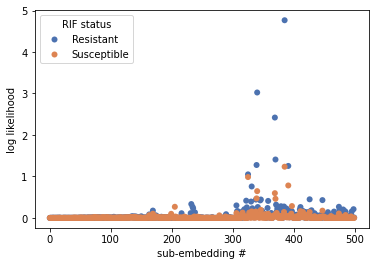

In [49]:
tempR = pd.DataFrame(
    {
        'log likelihood': logprob_res,
        'RIF status': ['Resistant' for _ in range(len(logprob_res))]
    }
)

tempS = pd.DataFrame(
    {
        'log likelihood': logprob_sus,
        'RIF status': ['Susceptible' for _ in range(len(logprob_sus))]
    }
)

df_viz = (
        pd.concat([tempR, tempS],axis=0)
            .reset_index()
            .rename(columns={'index':'sub-embedding #'})
)

sns.scatterplot(data=df_viz, 
                x='sub-embedding #', 
                y='log likelihood', 
                hue='RIF status',
                palette='deep',
                edgecolor='none'
)

plt.savefig('figure_loglikelihood_std.png', dpi=1000)

# Old code below

In [1]:
!pip install umap-learn

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import numpy as np
import pandas as pd
import umap

from tqdm import tqdm

In [31]:
basedir = '/scratch/users/benson97'
seqs = np.load(basedir + '/rif_seqs.npy')
uniqueids = np.load(basedir + '/rif_unique_ids.npy')
labels = pd.read_csv(basedir + '/rif_labels.csv')

In [32]:
temp = pd.concat([
    pd.DataFrame({'UNIQUEID': uniqueids}),
    pd.DataFrame({'SEQ': seqs})
], axis=1)

df = pd.merge(labels, temp, on='UNIQUEID', how='left')

In [34]:
seqs = seqs[1074:]
uniqueids = uniqueids[1074:]

In [35]:
"""
    Only samples [4322, 4431, 4687, 7254, 9466, 9751]
    do not share the same last 10 characters (with every
    other sample.)
"""

end_seq = seqs[0][-10:]
check = []
for i, seq in enumerate(seqs):
    if seq[-10:] != end_seq:
        check.append(i)
print(check)

[3248, 3357, 3613, 6180, 8392, 8677]


In [36]:
seq_len = len(seqs[0]) # should be 500
check = []
for i in tqdm(range(seq_len)):
    seen = set()
    for j in range(len(seqs)):
        seen.add(seqs[j][i])
    check.append(len(seen))
check = np.array(check)

100%|██████████| 500/500 [00:06<00:00, 75.30it/s]


In [37]:
from collections import Counter
indices = np.nonzero(check > 1)[0]
counters = []
for i in tqdm(indices):
    c = Counter()
    for j in range(len(seqs)):
        c[seqs[j][i]] += 1
    counters.append(c)

100%|██████████| 90/90 [00:01<00:00, 58.97it/s]


In [40]:
maf_count_cutoff = 10

high_maf = []
for i in range(len(counters)):
    c = counters[i]
    if c.most_common()[::-1][-2][1] > maf_count_cutoff:
        high_maf.append((indices[i], c))
print(high_maf)

[(325, Counter({'T': 11069, 'C': 105, 'G': 11})), (330, Counter({'C': 11170, 'A': 14, 'G': 1})), (331, Counter({'A': 11155, 'C': 16, 'T': 14})), (335, Counter({'C': 11172, 'T': 13})), (339, Counter({'G': 11025, 'T': 157, 'C': 3})), (340, Counter({'A': 10584, 'T': 564, 'G': 35, 'C': 2})), (369, Counter({'C': 10757, 'G': 206, 'T': 168, 'A': 54})), (370, Counter({'A': 11039, 'T': 74, 'G': 57, 'C': 15})), (385, Counter({'C': 8157, 'T': 2965, 'G': 61, 'X': 1, 'A': 1})), (386, Counter({'G': 11144, 'C': 24, 'T': 17})), (391, Counter({'T': 11061, 'C': 123, 'A': 1}))]


In [43]:
print(
    116/len(uniqueids),
    (564 + 35 + 2)/len(uniqueids),
    (206 + 169 + 54)/len(uniqueids),
    (2965 + 61 + 2)/len(uniqueids)
)

0.010371032632990612 0.053732677693339295 0.03835493965131873 0.27071971390254806


In [44]:
print(
    21/1073,
    42/1073,
    28/1073,
    145/1073
)

0.0195712954333644 0.0391425908667288 0.0260950605778192 0.13513513513513514


In [39]:
print(high_maf)

[(325, Counter({'T': 11069, 'C': 105, 'G': 11})), (330, Counter({'C': 11170, 'A': 14, 'G': 1})), (331, Counter({'A': 11155, 'C': 16, 'T': 14})), (335, Counter({'C': 11172, 'T': 13})), (339, Counter({'G': 11025, 'T': 157, 'C': 3})), (340, Counter({'A': 10584, 'T': 564, 'G': 35, 'C': 2})), (369, Counter({'C': 10757, 'G': 206, 'T': 168, 'A': 54})), (370, Counter({'A': 11039, 'T': 74, 'G': 57, 'C': 15})), (385, Counter({'C': 8157, 'T': 2965, 'G': 61, 'X': 1, 'A': 1})), (386, Counter({'G': 11144, 'C': 24, 'T': 17})), (391, Counter({'T': 11061, 'C': 123, 'A': 1}))]


In [ ]:
# [(325, Counter({'T': 1053, 'C': 21})),
#  (340, Counter({'A': 1032, 'G': 26, 'T': 13, 'C': 3})),
#  (369, Counter({'C': 1046, 'T': 16, 'G': 10, 'A': 2})),
#  (385, Counter({'C': 929, 'T': 145}))]

In [30]:
high_maf

[(325, Counter({'T': 1053, 'C': 21})),
 (340, Counter({'A': 1032, 'G': 26, 'T': 13, 'C': 3})),
 (369, Counter({'C': 1046, 'T': 16, 'G': 10, 'A': 2})),
 (385, Counter({'C': 929, 'T': 145}))]

In [51]:
feature_set = []
for pair in high_maf:
    feature_set.append(
        (
           pair[0],
           pair[1].most_common()[::-1][-1][0]
        )
    )

In [ ]:
# [(325, Counter({'T': 12122, 'C': 126, 'G': 11})),
#  (330, Counter({'C': 12244, 'A': 14, 'G': 1})),
#  (331, Counter({'A': 12228, 'C': 17, 'T': 14})),
#  (335, Counter({'C': 12246, 'T': 13})),
#  (339, Counter({'G': 12092, 'T': 164, 'C': 3})),
#  (340, Counter({'A': 11616, 'G': 61, 'T': 577, 'C': 5})),
#  (358, Counter({'C': 12245, 'T': 11, 'A': 2, 'G': 1})),
#  (369, Counter({'C': 11803, 'T': 184, 'G': 216, 'A': 56})),
#  (370, Counter({'A': 12105, 'G': 61, 'T': 78, 'C': 15})),
#  (385, Counter({'C': 9086, 'T': 3110, 'G': 61, 'X': 1, 'A': 1})),
#  (386, Counter({'G': 12217, 'C': 25, 'T': 17})),
#  (391, Counter({'T': 12127, 'C': 131, 'A': 1})),
#  (474, Counter({'A': 12248, 'G': 11}))]

In [52]:
high_maf

[(325, Counter({'T': 12122, 'C': 126, 'G': 11})),
 (330, Counter({'C': 12244, 'A': 14, 'G': 1})),
 (331, Counter({'A': 12228, 'C': 17, 'T': 14})),
 (335, Counter({'C': 12246, 'T': 13})),
 (339, Counter({'G': 12092, 'T': 164, 'C': 3})),
 (340, Counter({'A': 11616, 'G': 61, 'T': 577, 'C': 5})),
 (358, Counter({'C': 12245, 'T': 11, 'A': 2, 'G': 1})),
 (369, Counter({'C': 11803, 'T': 184, 'G': 216, 'A': 56})),
 (370, Counter({'A': 12105, 'G': 61, 'T': 78, 'C': 15})),
 (385, Counter({'C': 9086, 'T': 3110, 'G': 61, 'X': 1, 'A': 1})),
 (386, Counter({'G': 12217, 'C': 25, 'T': 17})),
 (391, Counter({'T': 12127, 'C': 131, 'A': 1})),
 (474, Counter({'A': 12248, 'G': 11}))]

In [53]:
data = []
for i, row in tqdm(df.iterrows()):
    features = []
    for pair in feature_set:
        if row['SEQ'][int(pair[0])] == pair[1]:
            features.append(0)
        else:
            features.append(1)
    data.append(features)

12072it [00:01, 6398.43it/s]


In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [60]:
df

,UNIQUEID,RIF_BINARY_PHENOTYPE,SEQ
0,site.02.subj.0001.lab.2014222001.iso.1,S,ATCACGTCGTCGACGCTGACCGAAGAAGACGTCGTGGCCACCATCG...
1,site.02.subj.0002.lab.2014222005.iso.1,S,ATCACGTCGTCGACGCTGACCGAAGAAGACGTCGTGGCCACCATCG...
2,site.02.subj.0004.lab.2014222010.iso.1,S,ATCACGTCGTCGACGCTGACCGAAGAAGACGTCGTGGCCACCATCG...
3,site.02.subj.0005.lab.2014222011.iso.1,S,ATCACGTCGTCGACGCTGACCGAAGAAGACGTCGTGGCCACCATCG...
4,site.02.subj.0006.lab.2014222013.iso.1,S,ATCACGTCGTCGACGCTGACCGAAGAAGACGTCGTGGCCACCATCG...
...,...,...,...
12067,site.20.subj.SCH8604398.lab.YA00134621.iso.1,S,ATCACGTCGTCGACGCTGACCGAAGAAGACGTCGTGGCCACCATCG...
12068,site.20.subj.SCH8604399.lab.YA00134971.iso.1,S,ATCACGTCGTCGACGCTGACCGAAGAAGACGTCGTGGCCACCATCG...
12069,site.20.subj.SCH8608291.lab.YA00135762.iso.1,R,ATCACGTCGTCGACGCTGACCGAAGAAGACGTCGTGGCCACCATCG...
12070,site.20.subj.SCH8608295.lab.YA00134623.iso.1,S,ATCACGTCGTCGACGCTGACCGAAGAAGACGTCGTGGCCACCATCG...


In [61]:
labels = []
for l in df['RIF_BINARY_PHENOTYPE']:
    if l == 'R': 
        labels.append(1)
    else:
        labels.append(0)

In [65]:
len(data[0])

13

In [67]:
X_train, X_test, y_train, y_test = train_test_split(data,
                                                   labels,
                                                   test_size=0.4,
                                                   random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_test, 
                                               y_test, 
                                               test_size=0.5, 
                                               random_state=42)

In [68]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

test_pred = clf.predict(X_val)
report = classification_report(
                      y_val,
                      test_pred,
                      output_dict=True)


In [69]:
report

{'0': {'precision': 0.9582772543741588,
  'recall': 0.9557046979865772,
  'f1-score': 0.956989247311828,
  'support': 1490.0},
 '1': {'precision': 0.9288793103448276,
  'recall': 0.9329004329004329,
  'f1-score': 0.9308855291576674,
  'support': 924.0},
 'accuracy': 0.9469759734879868,
 'macro avg': {'precision': 0.9435782823594931,
  'recall': 0.9443025654435051,
  'f1-score': 0.9439373882347477,
  'support': 2414.0},
 'weighted avg': {'precision': 0.9470246859055996,
  'recall': 0.9469759734879868,
  'f1-score': 0.9469976004292909,
  'support': 2414.0}}

In [18]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X_reduced = PCA(n_components=2).fit_transform(data)

NameError: name 'data' is not defined

In [12]:
import matplotlib.pyplot as plt

In [13]:
x, y = np.split(X_reduced, 2, axis=1)
x = x.flatten()
y = y.flatten()

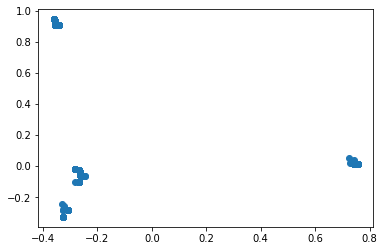

In [14]:
plt.scatter(x, y)

In [3]:
log_probs = np.load(basedir + '/rif_log_prob_0_500.npy')

In [4]:
data = [a[0] for a in log_probs]

In [5]:
data[0].shape

(500,)

In [6]:
log_probs.shape

(12072, 1, 500)

In [11]:
log_probs = np.load(basedir + '/rif_log_prob_0_500.npy')

means = []
stds = []
for i in tqdm(range(500)):
    means.append(np.mean(log_probs[:,:,i]))
    stds.append(np.std(log_probs[:,:,i]))

100%|██████████| 500/500 [00:00<00:00, 2238.00it/s]


In [10]:
import matplotlib.pyplot as plt

In [13]:
df = pd.concat([
    labels,
    pd.DataFrame({'LOGPROB':data})
], axis=1)

In [50]:
sus_df = df[df.RIF_BINARY_PHENOTYPE == 'S']
res_df = df[df.RIF_BINARY_PHENOTYPE == 'R']

In [65]:
log_probs = np.array(res_df['LOGPROB'].to_list())
log_probs.shape

(4662, 500)

In [20]:
log_probs = np.array(df['LOGPROB'].to_list())
means = []
stds = []
for i in tqdm(range(500)):
    means.append(np.mean(log_probs[:,i]))
    stds.append(np.std(log_probs[:,i]))

100%|██████████| 500/500 [00:00<00:00, 2765.91it/s]


In [55]:
# log_probs = sus_df['LOGPROB'].to_list()
# means = []
# stds = []
# for i in tqdm(range(500)):
#     means.append(np.mean(log_probs[:,:,i]))
#     stds.append(np.std(log_probs[:,:,i]))

  0%|          | 0/500 [00:00<?, ?it/s]


TypeError: list indices must be integers or slices, not tuple

In [15]:
means = np.array(means)
stds = np.array(stds)

In [4]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

df = pd.concat([
    labels,
    pd.DataFrame({'LOGPROB':data})
], axis=1)

log_probs = np.array(df['LOGPROB'].to_list())

means = []
stds = []
for i in tqdm(range(500)):
    means.append(np.mean(log_probs[:,i]))
    stds.append(np.std(log_probs[:,i]))

means = np.array(means)
stds = np.array(stds)

# plt.scatter([i for i in range(500)], means)
plt.scatter([i for i in range(500)], stds)
# plt.scatter([i for i in range(500)], means - stds)

NameError: name 'labels' is not defined

In [ ]:
std

ValueError: x and y must be the same size

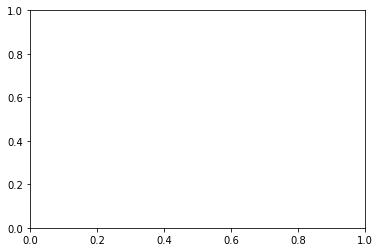

In [16]:
plt.scatter([i for i in range(500)], means)
plt.scatter([i for i in range(500)], means + stds)
plt.scatter([i for i in range(500)], means - stds)

In [26]:
np.argsort(means + stds)

array([ 57, 132, 180, 146,  31,  19,  38, 127,  50,  34,  90,  28,   4,
        17,   8,  14,  13,  35,  18,  52,   7,   5,  32,  25,  70,  42,
         1,  10,  23,   9,  85, 198,  47,   0,   2,   3,  55,  37,   6,
       177,  67,  33,  26,  16,  41,  59,  44,  43,  20,  11,  40,  22,
       195,  76, 114,  93,  69, 162,  29, 157,  12,  24, 168,  36,  21,
        66, 163,  15,  97,  39,  51,  88,  58,  49,  30,  48,  81, 159,
        56,  64,  60,  65, 115,  27, 118, 183, 116,  45,  94,  46, 126,
       141,  96, 117, 166, 190,  77, 192,  84,  87,  63, 189,  54,  75,
       156,  68, 124,  78, 153, 174, 150,  72, 186, 105, 154,  71,  79,
        53, 120,  91, 100, 111,  89, 145, 102,  99,  73,  61, 184,  95,
       101,  83,  92,  80, 165,  74,  98,  86, 109,  82, 144, 147, 104,
       103, 110, 182, 181, 129,  62, 112, 155, 121, 113, 199, 160, 137,
       187, 161, 193, 178, 108, 164, 175, 176, 133, 171, 128, 135, 196,
       123, 167, 107, 152, 149, 173, 143, 188, 130, 172, 194, 11

In [3]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

mypath = '/scratch/users/benson97/embeddings_rif_3/'
resultspath = mypath + 'results/' + 'rif_predictions.npy'
df = pd.read_csv('/scratch/users/benson97/' + 'rif_labels.csv')

# modify the number of sites as 
# we upload more sites to Sherlock...
sites = [
    '02',
#     '03',
#     '04',
#     '05',
#     '06',
#     '08',
#     '10',
#     '11',
#     '14',
#     '17',
#     '20'
]

site_dfs = []
for s in sites:
    site_dfs.append(
        df[df.UNIQUEID.str.contains('site.' + s)].reset_index(drop=True)
    )

df = pd.concat(site_dfs).reset_index(drop=True)
print(len(df))

1062


In [25]:
import os

def get_site(uniqueid):
    return uniqueid.split('.')[1]

X = []
label = []
for uniqueid in tqdm(df['UNIQUEID']):
    if not os.path.exists(mypath + 'site_' + get_site(uniqueid) + '/' + uniqueid + '.npy'):
        print('Oh no! ' + uniqueid + ' is missing!')
    else:
        X.append(
            np.load(mypath + 'site_' + get_site(uniqueid) + '/' + uniqueid + '.npy')[3]
        )
#        X.append(
#             np.load(mypath + 'site_' + get_site(uniqueid) + '/' + uniqueid + '.npy')
#         )
        
X = pd.DataFrame({'EMBED':X})

100%|██████████| 1062/1062 [00:07<00:00, 137.84it/s]


In [14]:
X

,EMBED
0,"[0.224609375, 0.14453125, 0.0186767578125, 0.0..."
1,"[0.224609375, 0.14453125, 0.0186767578125, 0.0..."
2,"[0.224609375, 0.14453125, 0.0186767578125, 0.0..."
3,"[0.224609375, 0.14453125, 0.0186767578125, 0.0..."
4,"[0.224609375, 0.14453125, 0.0186767578125, 0.0..."
...,...
1057,"[0.224609375, 0.142578125, 0.0181884765625, 0...."
1058,"[0.224609375, 0.14453125, 0.0186767578125, 0.0..."
1059,"[0.224609375, 0.14453125, 0.0186767578125, 0.0..."
1060,"[0.224609375, 0.14453125, 0.0186767578125, 0.0..."


In [11]:
labels = [0 if s == 'S' else 1 for s in df['RIF_BINARY_PHENOTYPE']]

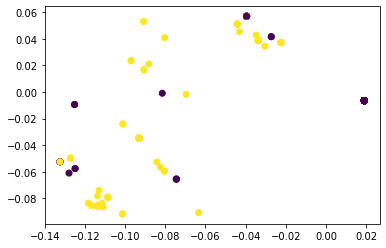

In [26]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X_reduced = PCA(n_components=2).fit_transform(X['EMBED'].to_list())

import matplotlib.pyplot as plt

x, y = np.split(X_reduced, 2, axis=1)
x = x.flatten()
y = y.flatten()

plt.scatter(x, y, c=labels)

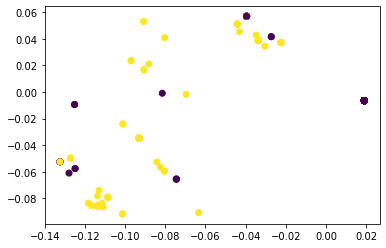

In [27]:
plt.scatter(x, y, c=labels)

In [17]:
X_reduced

array([[  5.57212979,   3.99582356],
       [  5.57212979,   3.99582356],
       [  5.57212979,   3.99582356],
       ...,
       [  5.57212979,   3.99582356],
       [  5.57212979,   3.99582356],
       [ -4.8106577 , -24.03492651]])

In [29]:
pca = PCA(n_components=10).fit(X['EMBED'].to_list())

In [28]:
pca.explained_variance_ratio_

array([0.50451237, 0.21904293, 0.09964399, 0.04879728, 0.02528585,
       0.02134213, 0.01680007, 0.01432614, 0.00706009, 0.0063367 ])

In [21]:
pca.__dict__

{'n_components': 10,
 'copy': True,
 'whiten': False,
 'svd_solver': 'auto',
 'tol': 0.0,
 'iterated_power': 'auto',
 'n_oversamples': 10,
 'power_iteration_normalizer': 'auto',
 'random_state': None,
 'n_features_in_': 819200,
 '_fit_svd_solver': 'randomized',
 'mean_': array([0.22462961, 0.14409079, 0.01851216, ..., 0.44534009, 0.55307829,
        0.27158782]),
 'n_samples_': 1062,
 'components_': array([[-4.81355723e-06,  2.86972050e-05,  1.30617101e-05, ...,
          6.34191184e-04,  1.26619870e-03,  2.89801252e-04],
        [ 1.14198032e-06,  5.70295384e-05,  1.33288321e-05, ...,
          4.91964558e-04,  1.42629591e-03, -1.86821070e-05],
        [-6.69280760e-06, -1.24273554e-05, -5.26642398e-06, ...,
          2.52179619e-04, -7.37792489e-04,  3.42131891e-04],
        ...,
        [-1.30290422e-05, -7.66559998e-06,  5.00436996e-06, ...,
          5.74835275e-04,  1.19147429e-05,  5.74559627e-04],
        [-3.04232570e-05, -2.79046580e-05,  1.61464092e-05, ...,
          9.4541

# UMAP experiment

In [33]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 5.3 MB/s eta 0:00:00ta 0:00:01


In [11]:
!pip install scikit-learn
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


In [50]:
import umap
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

mypath = '/scratch/users/benson97/embeddings_rif/'
df = pd.read_csv('/scratch/users/benson97/' + 'rif_labels.csv')

In [5]:
import os

def get_site(uniqueid):
    return uniqueid.split('.')[1]

X = []
label = []
for uniqueid in tqdm(df['UNIQUEID']):
    if not os.path.exists(mypath + 'site_' + get_site(uniqueid) + '/' + uniqueid + '.npy'):
        print('Oh no! ' + uniqueid + ' is missing!')
    else:
        X.append(
            np.load(mypath + 'site_' + get_site(uniqueid) + '/' + uniqueid + '.npy')[249]
        )
        
X = pd.DataFrame({'EMBED':X})

100%|██████████| 12072/12072 [08:34<00:00, 23.47it/s]


In [51]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(scaled_data)

NameError: name 'scaled_data' is not defined

In [39]:
location = []
for uniqueid in df['UNIQUEID']:
    location.append(int(uniqueid.split('.')[1]))
df = pd.concat(
    [df, pd.DataFrame({'SITEID':location})],
    axis=1
)

In [16]:
embedding = reducer.fit_transform(scaled_data)

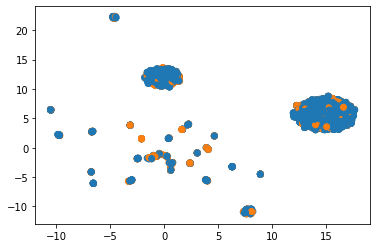

In [44]:
plt.scatter(embedding[:,0], 
            embedding[:,1],
           c=[sns.color_palette()[1] if x=='R' else sns.color_palette()[0] for x in df['RIF_BINARY_PHENOTYPE']]
           )

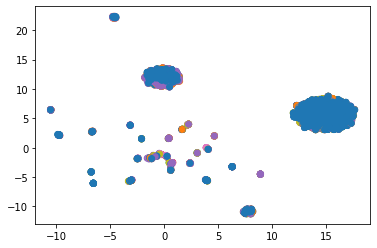

In [42]:
plt.scatter(embedding[:,0], 
            embedding[:,1],
           c=[sns.color_palette(n_colors=21)[x] for x in df['SITEID']]
           )